In [1]:
pip -q install diffusers transformers accelerate torch xformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.1/109.1 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 119.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 83.5 MB/s eta 0:00:00


In [3]:
import ipywidgets as widgets
from IPython.display import display
from PIL import Image,ImageDraw,ImageFont
import os

# Создание виджетов для ввода текста
prompt_widget = widgets.Text(
    value='',
    placeholder='Введите positive prompt...',
    description='positive:',
)
negative_prompt_widget = widgets.Text(
    value='',
    placeholder='Введите negative prompt...',
    description='negative:',
)

# Создание слайдеров
strength_widget = widgets.FloatSlider(value=0.5,min=0.5,max=2.0,step=0.1,
    description='Strength:',)
controlnet_conditioning_scale_widget = widgets.FloatSlider(value=0.5,min=0.5,max=2.0,step=0.1,
    description='Controlnet conditioning scale:',
)

prompt_value = ""
negative_prompt_value = ""

# Функция-обработчик для отправки формы
def handle_submit(sender):
    global prompt_value, negative_prompt_value

    # Проверка, какой виджет вызвал функцию
    if sender == prompt_widget:
        prompt_value = sender.value
        print(f"Тема: {prompt_value}")
    elif sender == negative_prompt_widget:
        negative_prompt_value = sender.value
        print(f"Текст: {negative_prompt_value}")
# Функция-обработчик для слайдеров
def handle_slider_change(change):
    global strength_value, controlnet_conditioning_scale_value

    # Проверка, какой слайдер вызвал функцию
    if change.owner == strength_widget:
        strength_value = change.new
    elif change.owner == controlnet_conditioning_scale_widget:
        controlnet_conditioning_scale_value = change.new


def add_border(image, border_width, text=None, save_path=None):
   """функция добавляет подпись на сгенерированное изображение
   можно использовать для быстрого просмотра результатов при тесте сетки параметров"""
    # Определяем новые размеры изображения с учетом границы и текста
    new_width = image.width
    new_height = image.height + border_width
    # Создаем новое изображение с черным фоном и новыми размерами
    new_image = Image.new("RGB", (new_width, new_height), "black")
    # Копируем исходное изображение в новое изображение смещением вниз
    new_image.paste(image, (0, border_width))
    # Рисуем текст на новой области
    if text:
        draw = ImageDraw.Draw(new_image)
        font = ImageFont.truetype("arial.ttf", 12)
        text_width, text_height = draw.textsize(text, font=font)
        text_position = ((new_width - text_width) // 2, (border_width - text_height) // 2)
        draw.text(text_position, text, font=font, fill="white")
    # Сохраняем изображение, если указан путь сохранения
    if save_path:
        new_image.save(save_path)

    return new_image



In [12]:
import torch
from diffusers import StableDiffusionControlNetImg2ImgPipeline,StableDiffusionControlNetPipeline, ControlNetModel, DDIMScheduler
from diffusers.utils import load_image

controlnet = ControlNetModel.from_pretrained("monster-labs/control_v1p_sd15_qrcode_monster",
                                             torch_dtype=torch.float16)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "dreamlike-art/dreamlike-photoreal-2.0",
    controlnet=controlnet,
    safety_checker=None,
    torch_dtype=torch.float16,
    use_safetensors=True)

pipe.enable_xformers_memory_efficient_attention()
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()

 ## EXAMPLE PROMPT
---
**POSITIVE PROMPT**
(masterpiece, top quality, best quality, extreme detailed, highest detailed, official art, beautiful and aesthetic:1.2), colorful, cowboy shot, beautiful face, solo, perfect body, 1girl, in space, spacecraft, spacesuit, sun rays, indoors, (wires and cables:1.1), (science fiction:1.2), porthole, illuminator, stars,fantasy, high contrast, ink strokes, explosions, over exposure, purple and red tone impression , abstract, ((watercolor painting by John Berkey and Jeremy Mann )) brush strokes, negative space,


---
**NEGATIVE PROMPT**
(badhandv4:1.2), (worst quality:2), (low quality:2), (normal quality:2), lowres, bad anatomy, bad hands, normal quality, ((monochrome)), ((grayscale))


---  
```
 width=768,
                  height=768,
                  guidance_scale=25,
                  controlnet_conditioning_scale=1.5,
                  generator=generator,
                  num_inference_steps=50,
                  
```

In [13]:
display(prompt_widget,negative_prompt_widget,strength_widget,controlnet_conditioning_scale_widget)
# Привязка функции-обработчика к событию отправки формы
prompt_widget.on_submit(handle_submit)
negative_prompt_widget.on_submit(handle_submit)
# Привязка функции-обработчика к событию изменения слайдеров
strength_widget.observe(handle_slider_change, names='value')
controlnet_conditioning_scale_widget.observe(handle_slider_change, names='value')

Text(value='(masterpiece, top quality, best quality, extreme detailed, highest detailed, official art, beautif…

Text(value='(badhandv4:1.2), (worst quality:2), (low quality:2), (normal quality:2), lowres, bad anatomy, bad …

FloatSlider(value=1.8, description='Strength:', max=2.0, min=0.5)

FloatSlider(value=1.5, description='Controlnet conditioning scale:', max=2.0, min=0.5)

In [10]:
from google.colab import files
from IPython.display import display, Image
def upload_image():
    uploaded = files.upload()
    return list(uploaded.keys())[0]

In [11]:
#Load qrcode img
source_path_qrcode = upload_image()
#Load ref image
source_ref_image = upload_image()


Загрузите изображение #1:


Saving google.png to google.png
Путь к изображению #1: google.png

Загрузите изображение #2:


Saving e4ff8170-550a-460e-9992-e3b1b905f1c1.png to e4ff8170-550a-460e-9992-e3b1b905f1c1 (1).png
Путь к изображению #2: e4ff8170-550a-460e-9992-e3b1b905f1c1 (1).png


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

controlnet_conditioning_scale= 1.5


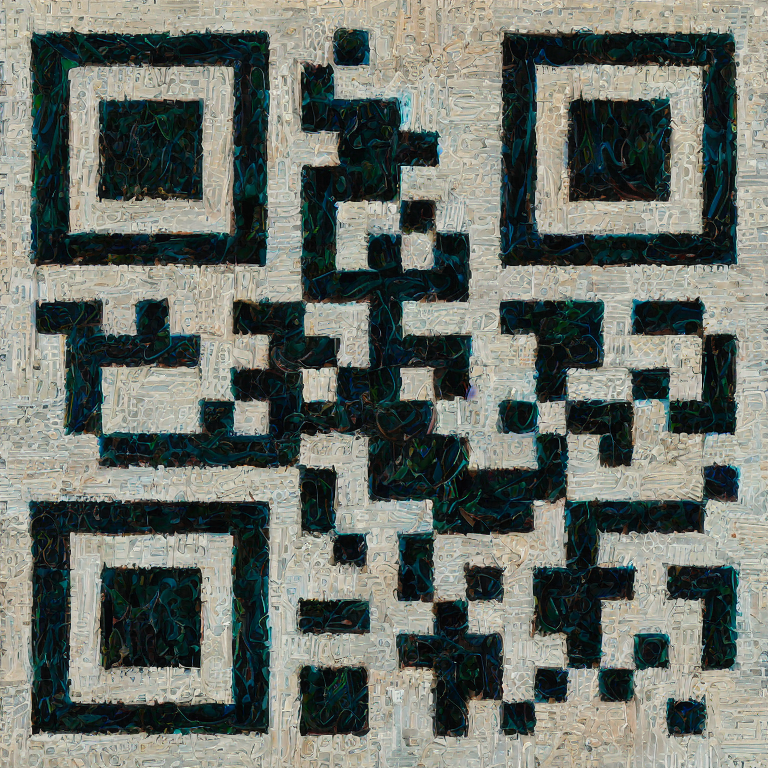

In [18]:
source_image = load_image(f"/content/{source_path_qrcode}")
init_image = load_image(f"/content/{source_ref_image}")
generator = torch.manual_seed(123121231)
image = pipe(prompt=prompt_value,negative_prompt=negative_prompt_value,
                    image=source_image,
                    width=768,height=768,guidance_scale=25,
                    controlnet_conditioning_scale= controlnet_conditioning_scale_value,
                    generator=generator,num_inference_steps=50,
                    )
image.images[0]